In [85]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import torch

In [86]:
import os

def encode_labels(labels: list):
    one_hot_encoder = {}
    for i in range(len(labels)):
        l = [0.]*len(labels)
        l[i] = 1.
        one_hot_encoder[labels[i]] = l
    return one_hot_encoder

def check_exp_fld(p):
    l=os.listdir(p)
    l=[x for x in l if "exp" in x]
    if len(l)==0:
        return os.path.join(p, "exp0")
        
    l.sort()
    return os.path.join(p, "exp" + str(int(l[len(l)-1].replace("exp", ""))+1))

In [87]:
meta_metrics= pd.read_pickle("df_train.pkl")

In [88]:
meta_metrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   graph        4500 non-null   object
 1   label_time   4500 non-null   object
 2   label_space  4500 non-null   object
dtypes: object(3)
memory usage: 105.6+ KB


In [89]:
meta_metrics.head()

,graph,label_time,label_space
0,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",dfs,dfs
1,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",best_first_search,best_first_search
2,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",best_first_search,best_first_search
3,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",best_first_search,astar
4,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",bidirectional_search,bidirectional_search


([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'dfs'),
  Text(1, 0, 'best_first_search'),
  Text(2, 0, 'bidirectional_search'),
  Text(3, 0, 'bfs'),
  Text(4, 0, 'dijkstra'),
  Text(5, 0, 'randomized_shortest_path'),
  Text(6, 0, 'astar')])

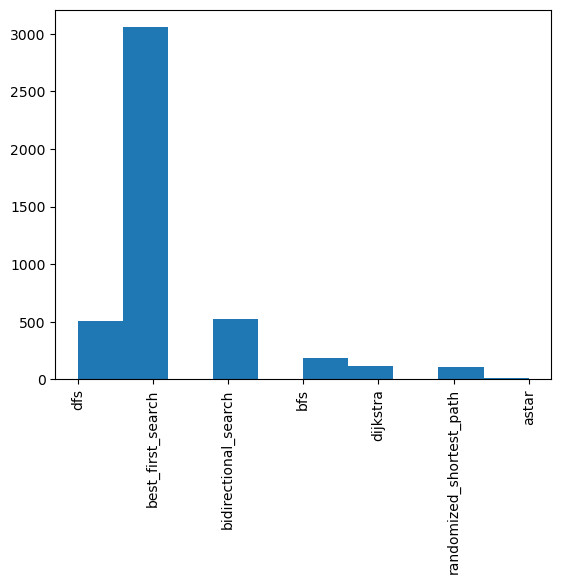

In [90]:
import matplotlib.pyplot as plt
plt.hist(meta_metrics.loc[:,"label_time"])
plt.xticks(rotation=90)

# Metrics calc

In [91]:
import statistics


def calculate_graph_size_features(graph):
    num_nodes = len(graph.nodes)
    num_edges = len(graph.edges)

    # Check for division by zero
    if num_edges != 0 and num_nodes != 0:
        return {
            'nodes': num_nodes,
            'edges': num_edges,
            'ratio_n_m': num_nodes / num_edges,
            'ratio_m_n': num_edges / num_nodes,
            'density': 2 * num_edges / (num_nodes * (num_nodes - 1))
        }
    else:
        # Handle the case where either num_edges or num_nodes is zero
        return {
            'nodes': num_nodes,
            'edges': num_edges,
            'ratio_n_m': 0,
            'ratio_m_n': 0,
            'density': 0
        }

def calculate_node_degree_stats(graph):
    degrees = list(dict(graph.degree()).values())
    degrees_np = np.array(degrees)

    # Check for diversity in degrees
    if len(set(degrees_np)) > 1:
        unique_degrees, counts = np.unique(degrees_np, return_counts=True)

        entropy_term = np.fromiter((p * np.log2(p) for p in (np.count_nonzero(degrees_np == x) / len(degrees_np) for x in set(degrees_np))), dtype=float)

        return {
            'min_degree': np.min(degrees_np),
            'max_degree': np.max(degrees_np),
            'mean_degree': np.mean(degrees_np),
            'median_degree': np.median(degrees_np),
            'q0.25_degree': np.percentile(degrees_np, 25),
            'q0.75_degree': np.percentile(degrees_np, 75),
            'variation_coefficient_degree': np.std(degrees_np) / np.mean(degrees_np),
            'entropy_degree': -np.sum(entropy_term)
        }
    else:
        # Handle the case where there is no diversity in degrees
        return {
            'min_degree': 0,
            'max_degree': 0,
            'mean_degree': 0,
            'median_degree': 0,
            'q0.25_degree': 0,
            'q0.75_degree': 0,
            'variation_coefficient_degree': 0,
            'entropy_degree': 0
        }


def calculate_maximal_clique_stats(graph, num_nodes):
    cliques = list(map(len, nx.enumerate_all_cliques(graph)))

    # Check for diversity in cliques
    if len(set(cliques)) > 1:
        return {
            'normalized_min_clique_size': min(cliques) / num_nodes,
            'normalized_max_clique_size': max(cliques) / num_nodes,
            'normalized_median_clique_size': statistics.median(cliques) / num_nodes,
            'normalized_q0.25_clique_size': statistics.quantiles(cliques, n=4)[0] / num_nodes,
            'normalized_q0.75_clique_size': statistics.quantiles(cliques, n=4)[2] / num_nodes,
            'normalized_variation_coefficient_clique_size': statistics.stdev(cliques) / statistics.mean(cliques),
            'normalized_entropy_clique_size': -sum(p * math.log2(p) for p in (cliques.count(x) / len(cliques) for x in set(cliques))) / num_nodes
        }
    else:
        # Handle the case where there is no diversity in cliques
        return {
            'normalized_min_clique_size': 0,
            'normalized_max_clique_size': 0,
            'normalized_median_clique_size': 0,
            'normalized_q0.25_clique_size': 0,
            'normalized_q0.75_clique_size': 0,
            'normalized_variation_coefficient_clique_size': 0,
            'normalized_entropy_clique_size': 0
        }


In [92]:
import pandas as pd

# Load the train set
df_train = pd.read_pickle("df_train.pkl")

# Load the test set
df_test = pd.read_pickle("df_test.pkl")

# Define a function to extract the matrix and target from a DataFrame
def extract_matrix_and_target(df):
    matrix_column = "graph"
    target_time_column = "label_time"
    target_space_column = "label_space"
    
    matrices = df[matrix_column].tolist()
    targets_time = df[target_time_column].tolist()
    targets_space = df[target_space_column].tolist()

    return matrices, targets_time, targets_space

# Extract matrix and target for train set
train_graphs, train_targets_time, train_targets_space = extract_matrix_and_target(df_train)

# Extract matrix and target for test set
test_graphs, test_targets_time, test_targets_space = extract_matrix_and_target(df_test)

import networkx as nx
import numpy as np
import statistics
import math

# Loop through each graph in the train set
train_graph_metrics = []
for graph, t_t, t_s in zip(train_graphs, train_targets_time, train_targets_space):
    size_features = calculate_graph_size_features(graph)
    degree_stats = calculate_node_degree_stats(graph)
    clique_stats = calculate_maximal_clique_stats(graph, len(graph.nodes()))

    # Combine the metrics into one dictionary
    graph_metrics = {**size_features, **degree_stats, **clique_stats, 'target_time': t_t, 'target_space': t_s}
    
    train_graph_metrics.append(graph_metrics)

# Loop through each graph in the test set
test_graph_metrics = []
for graph, t_t, t_s in zip(test_graphs, test_targets_time, test_targets_space):
    graph_array = nx.to_numpy_array(graph)
    size_features = calculate_graph_size_features(graph)
    degree_stats = calculate_node_degree_stats(graph)
    clique_stats = calculate_maximal_clique_stats(graph, graph_array.shape[0])  # Use graph_array.shape[0] for the number of nodes
    
    # Combine the metrics into one dictionary
    graph_metrics = {**size_features, **degree_stats, **clique_stats, 'target_time': t_t, 'target_space': t_s}
    
    test_graph_metrics.append(graph_metrics)

# Convert train_graph_metrics and test_graph_metrics to DataFrames
train_df = pd.DataFrame(train_graph_metrics)
test_df = pd.DataFrame(test_graph_metrics)

train_df.to_pickle("df_train_W_meta_metrics.pkl")
test_df.to_pickle("df_test_W_meta_metrics.pkl")


---

# Neural first level

In [93]:
meta_metrics= pd.read_pickle("df_train_W_meta_metrics.pkl")

In [94]:
meta_metrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 22 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   nodes                                         4500 non-null   int64  
 1   edges                                         4500 non-null   int64  
 2   ratio_n_m                                     4500 non-null   float64
 3   ratio_m_n                                     4500 non-null   float64
 4   density                                       4500 non-null   float64
 5   min_degree                                    4500 non-null   int64  
 6   max_degree                                    4500 non-null   int64  
 7   mean_degree                                   4500 non-null   float64
 8   median_degree                                 4500 non-null   float64
 9   q0.25_degree                                  4500 non-null   f

In [95]:
print(len(meta_metrics))
meta_metrics.dropna(inplace=True)
print(len(meta_metrics))

4500
4500


In [96]:
features_numeric = list(range(20))
gt = [20]

In [97]:
meta_metrics.head()

,nodes,edges,ratio_n_m,ratio_m_n,density,min_degree,max_degree,mean_degree,median_degree,q0.25_degree,...,entropy_degree,normalized_min_clique_size,normalized_max_clique_size,normalized_median_clique_size,normalized_q0.25_clique_size,normalized_q0.75_clique_size,normalized_variation_coefficient_clique_size,normalized_entropy_clique_size,target_time,target_space
0,19,11,1.727273,0.578947,0.064327,0,3,1.157895,1.0,0.0,...,1.871019,0.052632,0.157895,0.052632,0.052632,0.105263,0.397478,0.059110,dfs,dfs
1,34,130,0.261538,3.823529,0.231729,3,12,7.647059,7.0,6.0,...,3.051602,0.029412,0.117647,0.058824,0.058824,0.088235,0.324626,0.046827,best_first_search,best_first_search
2,68,364,0.186813,5.352941,0.159789,3,18,10.705882,11.0,9.0,...,3.374558,0.014706,0.058824,0.029412,0.029412,0.044118,0.301528,0.022069,best_first_search,best_first_search
3,58,122,0.475410,2.103448,0.073805,1,10,4.206897,4.0,3.0,...,2.907696,0.017241,0.051724,0.034483,0.017241,0.034483,0.319693,0.020953,best_first_search,astar
4,96,131,0.732824,1.364583,0.028728,0,9,2.729167,2.0,1.0,...,2.686679,0.010417,0.031250,0.020833,0.010417,0.020833,0.330712,0.011580,bidirectional_search,bidirectional_search


In [98]:
# collapse all other classes, other than best_first_search
meta_metrics.loc[meta_metrics["target_time"] != "best_first_search", "target_time"] = "other"
meta_metrics.head()

,nodes,edges,ratio_n_m,ratio_m_n,density,min_degree,max_degree,mean_degree,median_degree,q0.25_degree,...,entropy_degree,normalized_min_clique_size,normalized_max_clique_size,normalized_median_clique_size,normalized_q0.25_clique_size,normalized_q0.75_clique_size,normalized_variation_coefficient_clique_size,normalized_entropy_clique_size,target_time,target_space
0,19,11,1.727273,0.578947,0.064327,0,3,1.157895,1.0,0.0,...,1.871019,0.052632,0.157895,0.052632,0.052632,0.105263,0.397478,0.059110,other,dfs
1,34,130,0.261538,3.823529,0.231729,3,12,7.647059,7.0,6.0,...,3.051602,0.029412,0.117647,0.058824,0.058824,0.088235,0.324626,0.046827,best_first_search,best_first_search
2,68,364,0.186813,5.352941,0.159789,3,18,10.705882,11.0,9.0,...,3.374558,0.014706,0.058824,0.029412,0.029412,0.044118,0.301528,0.022069,best_first_search,best_first_search
3,58,122,0.475410,2.103448,0.073805,1,10,4.206897,4.0,3.0,...,2.907696,0.017241,0.051724,0.034483,0.017241,0.034483,0.319693,0.020953,best_first_search,astar
4,96,131,0.732824,1.364583,0.028728,0,9,2.729167,2.0,1.0,...,2.686679,0.010417,0.031250,0.020833,0.010417,0.020833,0.330712,0.011580,other,bidirectional_search


In [99]:
scaler=StandardScaler()
X_scaled_train=scaler.fit_transform(meta_metrics.iloc[:, features_numeric])

In [100]:
Y_train = meta_metrics.iloc[:, gt].squeeze().to_numpy() #sqeeze for reducing to pd.Series because iloc gives dataframe
print(Y_train.shape)

(4500,)


In [101]:
labels_train1 = meta_metrics.iloc[:, gt].squeeze().unique().tolist()
print(labels_train1)

one_hot_encoder1 = encode_labels(labels_train1)
print(one_hot_encoder1)

['other', 'best_first_search']
{'other': [1.0, 0.0], 'best_first_search': [0.0, 1.0]}


In [102]:
from torch.utils.data import Dataset
from torch import Tensor

class MetaMetrics(Dataset):

  def __init__(self, X_mat, Y_mat, one_hot_encoder: dict):
    super().__init__()
    self.onehot = one_hot_encoder
    self.feat = X_mat
    self.labels = Y_mat

  def __getitem__(self, idx):
    target=self.onehot[self.labels[idx]]
    return Tensor(self.feat[idx,:]), Tensor(target) 

  def __len__(self):
    return len(self.feat)
  
ds1 = MetaMetrics(X_scaled_train, Y_train, one_hot_encoder1)

In [103]:
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print("[i] USING CUDA")
    else:
        device = torch.device('cpu') # don't have GPU 
        print("[i] USING CPU")
    return device

device = get_device() #setting up the DL device

[i] USING CUDA


In [104]:
num_epochs1 = 100
batch_size1 = 100
#mini_batch_size = 64

In [105]:
from torch.utils.data import DataLoader, WeightedRandomSampler

class_sample_count=meta_metrics.groupby("target_time").count().iloc[:,0].squeeze().to_numpy()
weight = 1. / class_sample_count
samples_weight = [weight[labels_train1.index(Y_train[i])] for i in range(Y_train.shape[0])]

# Create a WeightedRandomSampler for the training set
sampler = WeightedRandomSampler(
    samples_weight, len(samples_weight), replacement=True)

dl1 = DataLoader(ds1, batch_size=batch_size1, sampler=sampler)
for x, y in iter(dl1):
    print(x.shape, y.shape)
    break

torch.Size([100, 20]) torch.Size([100, 2])


In [106]:
from torch import nn, optim

class Net_1(nn.Module):
    def __init__(self, isize, osize) -> None:
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(isize, 100),
            nn.LeakyReLU(0.2),
            nn.Linear(100,50),
            nn.LeakyReLU(0.2),
            nn.Linear(50, osize),
            nn.Softmax(dim=1)
        )
        self.loss = nn.functional.cross_entropy
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.0001)
        self.scheduler = None

    def forward(self, x):
        return self.model(x)

model1 = Net_1(20,2)

In [107]:
from torch.utils.tensorboard import SummaryWriter
import tensorboard

def train(epochs, dl):
        new_exp_name = check_exp_fld("./runs/tensorboard")
        writer=SummaryWriter(new_exp_name)

        for e in range(epochs):
            
            running_loss=0.
            for _,(x,y) in enumerate(dl):

                model1.optimizer.zero_grad()

                y_tilde = model1(x)
                loss=model1.loss(y_tilde, y)
                loss.backward()
                model1.optimizer.step()

                #stats --------------
                running_loss+=loss.item()

            writer.add_scalar("Loss/train", running_loss, e)

            

            if e%10 == 0:
                print("Finished epoch", e)        
        
        writer.close()

train(num_epochs1, dl1)

Finished epoch 0


Finished epoch 10
Finished epoch 20
Finished epoch 30
Finished epoch 40
Finished epoch 50
Finished epoch 60
Finished epoch 70
Finished epoch 80
Finished epoch 90


In [108]:
# Check if the directory exists, and if not, create it
save_dir = f'./models/{(model1.__class__.__name__).lower()}'
os.makedirs(save_dir, exist_ok=True)
# Save State Dict
torch.save(model1.state_dict(
), f'{save_dir}/{(model1.__class__.__name__).lower()}_{"binary-class"}_saved_model.pth')

---
# Second level

In [109]:
meta_metrics = pd.read_pickle("./df_train_W_meta_metrics.pkl")

In [110]:
print(len(meta_metrics))
meta_metrics.dropna(inplace=True)
print(len(meta_metrics))

4500
4500


In [111]:
#drop best_first_search
meta_metrics=meta_metrics[meta_metrics["target_time"]!="best_first_search"]

In [112]:
labels_train2 = meta_metrics.iloc[:, gt].squeeze().unique().tolist()
print(labels_train2)

['dfs', 'bidirectional_search', 'bfs', 'dijkstra', 'randomized_shortest_path', 'astar']


In [113]:
one_hot_encoder2 = encode_labels(labels_train2)
print(one_hot_encoder2)

{'dfs': [1.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'bidirectional_search': [0.0, 1.0, 0.0, 0.0, 0.0, 0.0], 'bfs': [0.0, 0.0, 1.0, 0.0, 0.0, 0.0], 'dijkstra': [0.0, 0.0, 0.0, 1.0, 0.0, 0.0], 'randomized_shortest_path': [0.0, 0.0, 0.0, 0.0, 1.0, 0.0], 'astar': [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]}


In [114]:
X_scaled_train=scaler.transform(meta_metrics.iloc[:, features_numeric])
print(X_scaled_train.shape)

(1441, 20)


In [115]:
Y_train = meta_metrics.iloc[:, gt].squeeze().to_numpy() #sqeeze for reducing to pd.Series because iloc gives dataframe
print(Y_train.shape)

(1441,)


In [116]:
from torch import nn, optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

class Net_2(nn.Module):
    def __init__(self, isize, osize) -> None:
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(isize, 512),
            nn.Tanh(),
            nn.Linear(512, 256),
            nn.Tanh(),
            nn.Linear(256, 256),
            nn.Tanh(),
            nn.Linear(256, 256),

            nn.Tanh(),
            nn.Linear(256, 256),

            nn.Tanh(),
            nn.Linear(256, 128),

            nn.Tanh(),
            nn.Linear(128, 64),

            nn.Tanh(),
            nn.Linear(64, 32),
            nn.Tanh(),
            nn.Linear(32, osize),
            nn.Softmax(dim=1)
        )
        self.loss = nn.functional.cross_entropy
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.0001)
        self.scheduler = None
        #CosineAnnealingWarmRestarts(self.optimizer, T_0=round((1/10)*b_size), T_mult=1, eta_min=0)

    def forward(self, x):
        return self.model(x)


def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.kaiming_uniform_(m.weight)
        m.bias.data.fill_(0.01)


model2 = Net_2(20, 6)

model2.apply(init_weights)

Net_2(
  (model): Sequential(
    (0): Linear(in_features=20, out_features=512, bias=True)
    (1): Tanh()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): Tanh()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): Tanh()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): Tanh()
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): Tanh()
    (10): Linear(in_features=256, out_features=128, bias=True)
    (11): Tanh()
    (12): Linear(in_features=128, out_features=64, bias=True)
    (13): Tanh()
    (14): Linear(in_features=64, out_features=32, bias=True)
    (15): Tanh()
    (16): Linear(in_features=32, out_features=6, bias=True)
    (17): Softmax(dim=1)
  )
)

In [117]:
ds2=MetaMetrics(X_scaled_train, Y_train,one_hot_encoder2)

In [118]:
num_epochs2=168
batch_size2=40

In [119]:
from torch.utils.data import DataLoader, WeightedRandomSampler

class_sample_count=meta_metrics.groupby("target_time").count().iloc[:,0].squeeze().to_numpy()
weight = 1. / class_sample_count
samples_weight = [weight[labels_train2.index(Y_train[i])] for i in range(Y_train.shape[0])]

# Create a WeightedRandomSampler for the training set
sampler = WeightedRandomSampler(
    samples_weight, len(samples_weight), replacement=True)

dl2 = DataLoader(ds2, batch_size=batch_size2, sampler=sampler)
for x, y in iter(dl1):
    print(x.shape, y.shape)
    break

torch.Size([100, 20]) torch.Size([100, 2])


In [120]:
from torch.utils.tensorboard import SummaryWriter
import tensorboard

def train2(epochs, dl):
        new_exp_name = check_exp_fld("./runs/tensorboard")
        writer=SummaryWriter(new_exp_name)

        for e in range(epochs):
            
            running_loss=0.
            for _,(x,y) in enumerate(dl):

                model2.optimizer.zero_grad()

                y_tilde = model2(x)

                loss=model2.loss(y_tilde, y)
                loss.backward()
                model2.optimizer.step()

                #stats --------------
                running_loss+=loss.item()

            writer.add_scalar("Loss/train2", running_loss, e)

            

            if e%10 == 0:
                print("Finished epoch", e)        
        
        writer.close()

train2(num_epochs2, dl2)

Finished epoch 0
Finished epoch 10
Finished epoch 20
Finished epoch 30
Finished epoch 40
Finished epoch 50
Finished epoch 60
Finished epoch 70
Finished epoch 80
Finished epoch 90
Finished epoch 100
Finished epoch 110
Finished epoch 120
Finished epoch 130
Finished epoch 140
Finished epoch 150
Finished epoch 160


In [121]:
# Check if the directory exists, and if not, create it
save_dir = f'./models/{(model2.__class__.__name__).lower()}'
os.makedirs(save_dir, exist_ok=True)
# Save State Dict
torch.save(model2.state_dict(
), f'{save_dir}/{(model2.__class__.__name__).lower()}_{"6-classes-class"}_saved_model.pth')

---
# Test
## Test 1st level

In [122]:
df_test = pd.read_pickle("./df_test_W_meta_metrics.pkl")
df_test.loc[df_test["target_time"] != "best_first_search", "target_time"] = "other"

In [123]:
X_scaled_test=scaler.transform(df_test.iloc[:, features_numeric])
print(X_scaled_test.shape)

(500, 20)


In [124]:
Y_test = df_test.iloc[:, gt].squeeze().to_numpy() #sqeeze for reducing to pd.Series because iloc gives dataframe
print(Y_test.shape)

(500,)


In [125]:
ds_test=MetaMetrics(X_scaled_test,Y_test, one_hot_encoder1)
dl_test = DataLoader(ds_test, batch_size=1)

F1-score: 0.8273493655160173


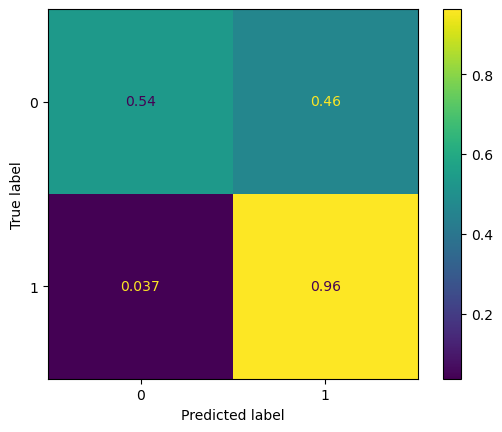

In [126]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

model1=Net_1(20,2)
model1.load_state_dict(torch.load("./models/net_1/net_1_binary-class_saved_model.pth"))

model1.eval()

actual_labels = []
predicted_labels = []
with torch.no_grad():
    for inputs, y in dl_test:
        actual_lab=int(torch.argmax(y))
        actual_labels.append(actual_lab)
        outputs1 = model1(inputs)
        pred_class = int(torch.argmax(outputs1))
        predicted_labels.append(pred_class)


conf_matrix = confusion_matrix(
    actual_labels, predicted_labels, normalize='true')
conf_disp = ConfusionMatrixDisplay(conf_matrix)
conf_disp.plot()

print("F1-score:", f1_score(actual_labels, predicted_labels, average="weighted"))

---
## Test 2nd level

In [127]:
df_test = pd.read_pickle("./df_test_W_meta_metrics.pkl")
df_test=df_test[df_test["target_time"] != "best_first_search"]
df_test.head()

,nodes,edges,ratio_n_m,ratio_m_n,density,min_degree,max_degree,mean_degree,median_degree,q0.25_degree,...,entropy_degree,normalized_min_clique_size,normalized_max_clique_size,normalized_median_clique_size,normalized_q0.25_clique_size,normalized_q0.75_clique_size,normalized_variation_coefficient_clique_size,normalized_entropy_clique_size,target_time,target_space
2,30,83,0.361446,2.766667,0.190805,2,10,5.533333,5.5,4.00,...,2.806239,0.033333,0.100000,0.066667,0.066667,0.066667,0.322118,0.045542,bidirectional_search,best_first_search
4,105,141,0.744681,1.342857,0.025824,0,9,2.685714,2.0,1.00,...,2.702194,0.009524,0.028571,0.019048,0.009524,0.019048,0.330766,0.010532,bidirectional_search,bidirectional_search
10,158,272,0.580882,1.721519,0.021930,0,9,3.443038,3.0,2.00,...,2.768246,0.006329,0.018987,0.012658,0.006329,0.012658,0.302662,0.006427,bidirectional_search,bidirectional_search
14,31,81,0.382716,2.612903,0.174194,2,8,5.225806,5.0,3.50,...,2.671264,0.032258,0.096774,0.064516,0.064516,0.064516,0.320045,0.042368,bidirectional_search,best_first_search
15,24,29,0.827586,1.208333,0.105072,0,5,2.416667,2.5,1.75,...,2.182932,0.041667,0.125000,0.083333,0.041667,0.083333,0.352734,0.049284,bidirectional_search,best_first_search


In [128]:
X_scaled_test=scaler.transform(df_test.iloc[:, features_numeric])
print(X_scaled_test.shape)

(145, 20)


In [129]:
Y_test = df_test.iloc[:, gt].squeeze().to_numpy() #sqeeze for reducing to pd.Series because iloc gives dataframe
print(Y_test.shape)

(145,)


In [130]:
ds_test=MetaMetrics(X_scaled_test,Y_test, one_hot_encoder2)
dl_test = DataLoader(ds_test, batch_size=1)

F1-score: 0.32679551311703475


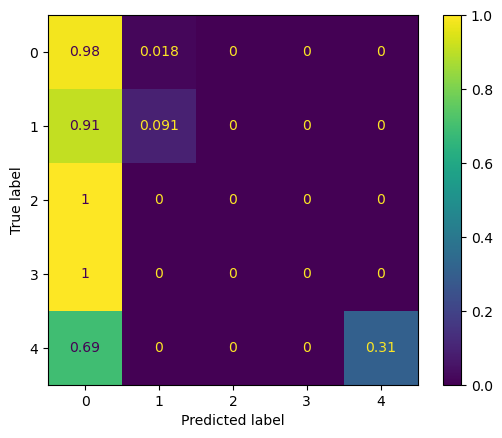

In [131]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

model1=Net_2(20,6)
model1.load_state_dict(torch.load("./models/net_2/net_2_6-classes-class_saved_model.pth"))

model2.eval()

actual_labels = []
predicted_labels = []
with torch.no_grad():
    for inputs, y in dl_test:
        actual_lab=int(torch.argmax(y))
        actual_labels.append(actual_lab)
        outputs2 = model2(inputs)
        pred_class = int(torch.argmax(outputs2))
        predicted_labels.append(pred_class)

conf_matrix = confusion_matrix(
    actual_labels, predicted_labels, normalize='true')
conf_disp = ConfusionMatrixDisplay(conf_matrix)
conf_disp.plot()

print("F1-score:", f1_score(actual_labels, predicted_labels, average="weighted"))